In [2]:
# import required libraries
import sklearn
import geopandas as gpd
import pandas as pd

In [54]:
%%time

# read the data
main_df = pd.read_csv('full_extract_ntl_temp_sentiment.csv')
embeddings_df = pd.read_csv('merged_embstats_full_extract_main.csv')

# remove duplicates
size = main_df.shape[0]
main_df = main_df.drop_duplicates(subset=['caseid'], keep='first')
print(f'{size-main_df.shape[0]} duplicates found in main_df. Removed!')

# join embeddings with the main data
main_df = main_df.merge(embeddings_df, on='caseid', how='left')
print(f'Size of dataframe after merging embeddings: {result_df.shape[0]}')

main_df.head()

2034 duplicates found in main_df. Removed!
Size of dataframe after merging embeddings: 11423
CPU times: user 1.18 s, sys: 280 ms, total: 1.46 s
Wall time: 1.47 s


caseid  weight_x  wave_x state_x        district_x urban_x gender_x  age_x   
0   10001  0.840547    2024      NE  East Khasi Hills   Urban     Male  18-29  \
1   10002  1.360886    2024      UT               Leh   Rural   Female    45+   
2   10002  1.360886    2024      UT               Leh   Rural   Female    45+   
3   10003  0.640417    2024      UT       Daman & Diu   Rural     Male  30-44   
4   10003  0.640417    2024      UT       Daman & Diu   Rural     Male  30-44   

                   caste_x  n7dy23_recode_x  ...  A62_count    A63_p2   
0  Scheduled Castes/Tribes                1  ...    3519450 -0.124567  \
1  Scheduled Castes/Tribes                1  ...    4837249 -0.206936   
2  Scheduled Castes/Tribes                1  ...    6508506 -0.221453   
3             Other Castes                1  ...      86148  0.032541   
4             Other Castes                1  ...      47012 -0.022207   

    A63_p90   A63_p95   A63_p98        A63_sum  A63_mean   A63_min   A63_max   
0  0.103406  0.124567  0.147697   43582.604336  0.012406 -0.267958  0.327812  \
1  0.093564  0.141730  0.267958 -117536.992772 -0.024344 -0.318893  0.346021   
2  0.103406  0.130165  0.160000 -248714.921995 -0.038288 -0.327812  0.318893   
3  0.221453  0.236463  0.244152   10633.937208  0.124858 -0.051734  0.355309   
4  0.206936  0.244152  0.259900    4060.501217  0.087937 -0.113741  0.355309   

   A63_count  
0    3519450  
1    4837249  
2    6508506  
3      86148  
4      47012  

[5 rows x 617 columns]

## Spatial splitting for ML model

CPU times: user 2.08 s, sys: 200 ms, total: 2.28 s
Wall time: 2.12 s


<Axes: >

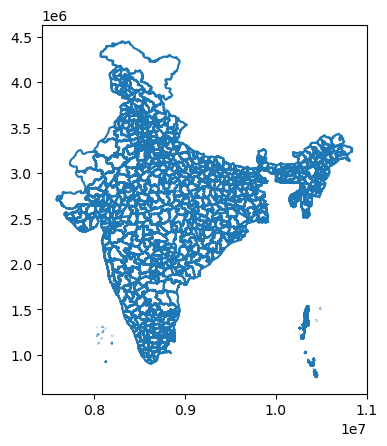

In [22]:
%%time

import geopandas as gpd

# read the districts shapefile
dist_gdf = gpd.read_file('India_District_2023_3857.gpkg')
dist_gdf.boundary.plot()

In [49]:
%%time

import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import pandas as pd

# Fast fishnet creation
def create_fishnet(gdf, cell_size):
    minx, miny, maxx, maxy = gdf.total_bounds
    x_coords = np.arange(minx, maxx + cell_size, cell_size)
    y_coords = np.arange(miny, maxy + cell_size, cell_size)
    xx, yy = np.meshgrid(x_coords[:-1], y_coords[:-1])
    
    grid_cells = [Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
                  for x, y in zip(xx.flatten(), yy.flatten())]
    
    return gpd.GeoDataFrame({'grid_id': range(len(grid_cells)), 'geometry': grid_cells}, crs=gdf.crs)

# No-adjacent test split
def no_adjacent_split(gdf, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    gdf = gdf.reset_index(drop=True)
    n_test = int(len(gdf) * test_size)
    
    # Build adjacency using spatial index (faster)
    sindex = gdf.sindex
    adjacency = {}
    for idx, geom in enumerate(gdf.geometry):
        possible_matches = list(sindex.intersection(geom.bounds))
        neighbors = [i for i in possible_matches if i != idx and gdf.geometry.iloc[i].touches(geom)]
        adjacency[idx] = neighbors
    
    # Greedy selection
    available = set(range(len(gdf)))
    test_indices = []
    
    while len(test_indices) < n_test and available:
        candidate = np.random.choice(list(available))
        test_indices.append(candidate)
        # Remove candidate and neighbors
        to_remove = {candidate} | set(adjacency.get(candidate, []))
        available -= to_remove
    
    train_indices = [i for i in range(len(gdf)) if i not in test_indices]
    return gdf.loc[train_indices], gdf.loc[test_indices]

# Fixed district assignment
def assign_districts(districts, train_grid, test_grid):
    districts = districts.reset_index(drop=True).copy()
    districts['orig_idx'] = districts.index
    districts['train_area'] = 0.0
    districts['test_area'] = 0.0
    
    # Calculate overlaps with proper index handling
    for split_type, grid in [('train', train_grid), ('test', test_grid)]:
        overlay = gpd.overlay(districts, grid, how='intersection')
        if not overlay.empty:
            # Group by original district index and sum areas
            area_sums = overlay.groupby('orig_idx')['geometry'].apply(lambda x: x.area.sum())
            # Map back to districts using orig_idx
            for orig_idx, area in area_sums.items():
                districts.loc[districts['orig_idx'] == orig_idx, f'{split_type}_area'] = area
    
    districts['split'] = (districts['train_area'] >= districts['test_area']).map({True: 'train', False: 'test'})
    return districts.drop('orig_idx', axis=1)

# Main execution
cell_size = 250000
print("Creating fishnet...")
fishnet = create_fishnet(dist_gdf, cell_size)
fishnet_filtered = fishnet[fishnet.intersects(dist_gdf.unary_union)]

print("Splitting with no-adjacent constraint...")
train_grid, test_grid = no_adjacent_split(fishnet_filtered, test_size=0.2, random_state=55)

print("Assigning districts...")
dist_with_splits = assign_districts(dist_gdf, train_grid, test_grid)

train_districts = dist_with_splits[dist_with_splits['split'] == 'train']
test_districts = dist_with_splits[dist_with_splits['split'] == 'test']

print(f"Results: {len(train_grid)} train grid, {len(test_grid)} test grid")
print(f"Districts: {len(train_districts)} train, {len(test_districts)} test")

Creating fishnet...
Splitting with no-adjacent constraint...
Assigning districts...
Results: 89 train grid, 22 test grid
Districts: 617 train, 116 test
CPU times: user 59.9 s, sys: 217 ms, total: 1min
Wall time: 1min


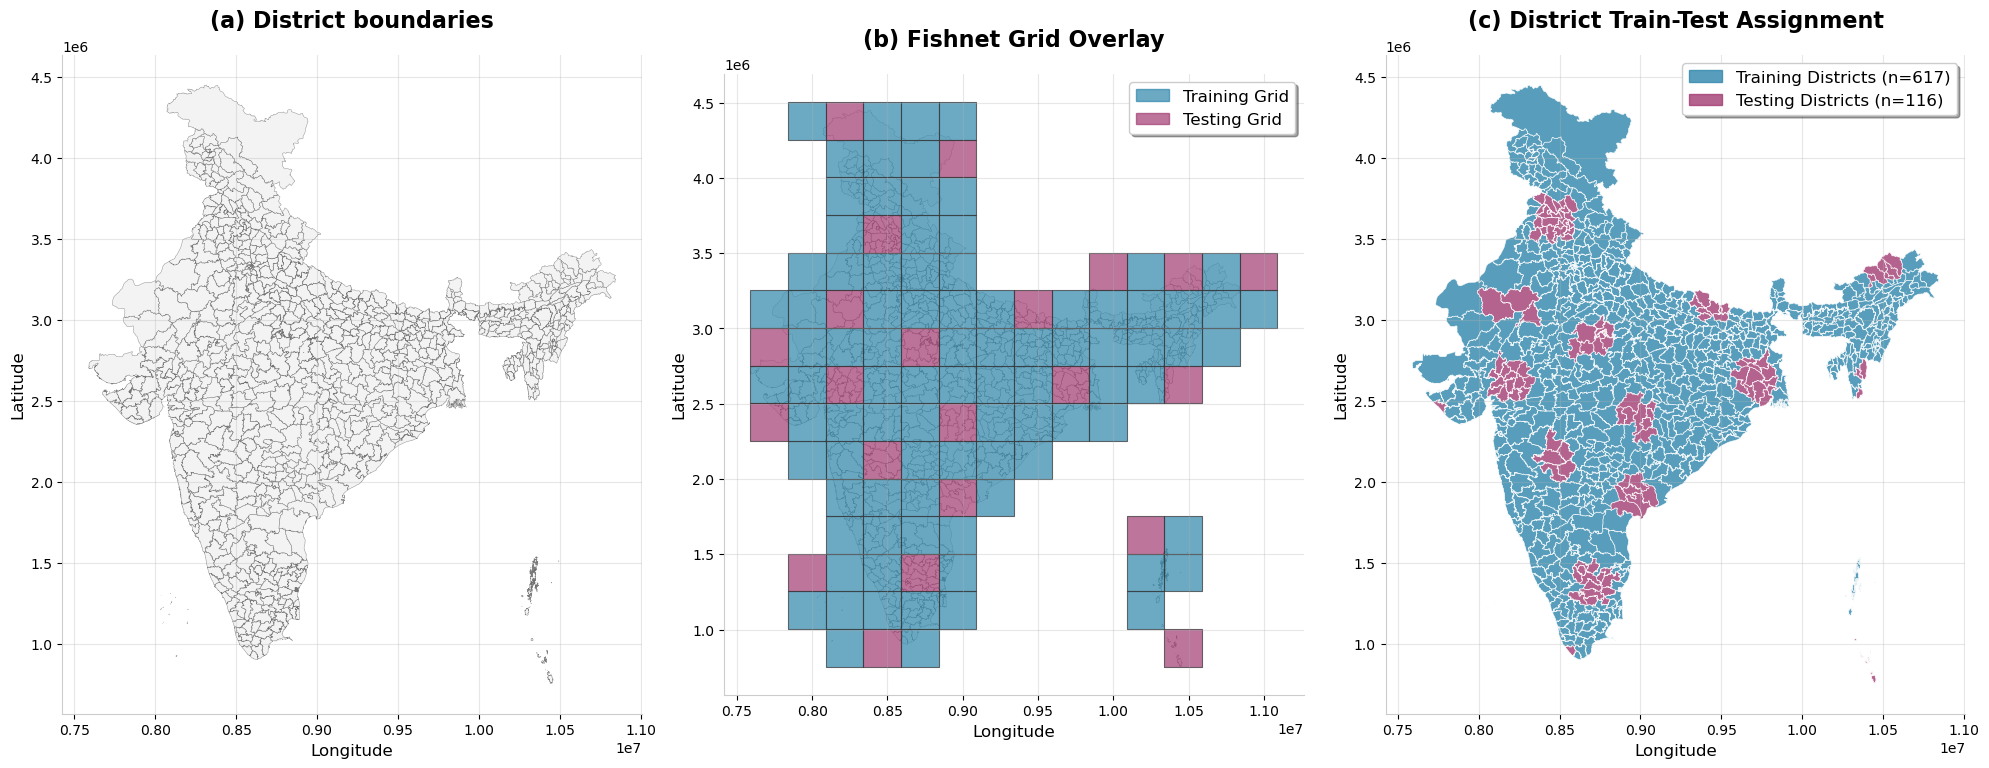

CPU times: user 23.6 s, sys: 652 ms, total: 24.2 s
Wall time: 23.7 s


In [53]:
%%time
import matplotlib.patches as mpatches

# Set up the figure with publication quality settings
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define colors
district_color = '#f0f0f0'
district_edge = '#666666'
train_color = '#2E86AB'  # Professional blue
test_color = '#A23B72'   # Professional red/purple
grid_color = '#333333'   # Dark gray for grid lines

# Plot 1: Original districts
dist_gdf.plot(ax=axes[0], 
             color=district_color, 
             edgecolor=district_edge, 
             linewidth=0.3, 
             alpha=0.8)
axes[0].set_title('(a) District boundaries', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].tick_params(labelsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Districts with fishnet overlay
dist_gdf.plot(ax=axes[1], 
             color=district_color, 
             edgecolor=district_edge, 
             linewidth=0.3, 
             alpha=0.6)
train_grid.plot(ax=axes[1], 
               facecolor=train_color, 
               edgecolor=grid_color, 
               linewidth=0.8, 
               alpha=0.7)
test_grid.plot(ax=axes[1], 
              facecolor=test_color, 
              edgecolor=grid_color, 
              linewidth=0.8, 
              alpha=0.7)

# Create manual legend for plot 2
train_patch = mpatches.Patch(color=train_color, alpha=0.7, label='Training Grid')
test_patch = mpatches.Patch(color=test_color, alpha=0.7, label='Testing Grid')
axes[1].legend(handles=[train_patch, test_patch], fontsize=12, loc='upper right', 
               frameon=True, fancybox=True, shadow=True)

axes[1].set_title('(b) Fishnet Grid Overlay', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].tick_params(labelsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Districts colored by train/test assignment
train_districts.plot(ax=axes[2], 
                    color=train_color, 
                    edgecolor='white', 
                    linewidth=0.5, 
                    alpha=0.8)
test_districts.plot(ax=axes[2], 
                   color=test_color, 
                   edgecolor='white', 
                   linewidth=0.5, 
                   alpha=0.8)

# Create manual legend for plot 3
train_district_patch = mpatches.Patch(color=train_color, alpha=0.8, 
                                     label=f'Training Districts (n={len(train_districts)})')
test_district_patch = mpatches.Patch(color=test_color, alpha=0.8, 
                                    label=f'Testing Districts (n={len(test_districts)})')
axes[2].legend(handles=[train_district_patch, test_district_patch], fontsize=12, 
               loc='upper right', frameon=True, fancybox=True, shadow=True)

axes[2].set_title('(c) District Train-Test Assignment', fontsize=16, fontweight='bold', pad=20)
axes[2].set_xlabel('Longitude', fontsize=12)
axes[2].set_ylabel('Latitude', fontsize=12)
axes[2].tick_params(labelsize=10)
axes[2].grid(True, alpha=0.3)

# Set equal aspect ratio for all subplots
for ax in axes:
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Save high-quality figure
fig.savefig('spatial_train_test_split.png', dpi=300, bbox_inches='tight', 
             facecolor='white', edgecolor='none')

In [58]:
dist_with_splits

state23 st_code                   dist23 di_code   
0    GUJARAT      24                    MORBI     673  \
1    GUJARAT      24                AHMADABAD     438   
2    GUJARAT      24                    ANAND     440   
3    GUJARAT      24          DEVBHUMI DWARKA     674   
4    GUJARAT      24                 JAMNAGAR     447   
..       ...     ...                      ...     ...   
728    ASSAM      18                 SONITPUR     301   
729    ASSAM      18  SOUTH SALMARA MANCACHAR     707   
730    ASSAM      18                 TINSUKIA     302   
731    ASSAM      18                 UDALGURI     617   
732    ASSAM      18       WEST KARBI ANGLONG     710   

                            st_di23     Shape_Leng    Shape_Area   
0                    GUJARAT, MORBI  539476.764723  4.791280e+09  \
1                GUJARAT, AHMADABAD  857254.094647  6.966374e+09   
2                    GUJARAT, ANAND  393046.690523  3.054307e+09   
3          GUJARAT, DEVBHUMI DWARKA  661732.986530  4.002784e+09   
4                 GUJARAT, JAMNAGAR  737428.071884  5.694271e+09   
..                              ...            ...           ...   
728                 ASSAM, SONITPUR  302021.098402  3.318736e+09   
729  ASSAM, SOUTH SALMARA MANCACHAR  234231.827116  6.578689e+08   
730                 ASSAM, TINSUKIA  419712.540770  3.677172e+09   
731                 ASSAM, UDALGURI  363765.338478  1.977228e+09   
732       ASSAM, WEST KARBI ANGLONG  430785.104037  2.957340e+09   

                            GeoName   GEOID   
0                    GUJARAT, MORBI  x24673  \
1                GUJARAT, AHMADABAD  x24438   
2                    GUJARAT, ANAND  x24440   
3          GUJARAT, DEVBHUMI DWARKA  x24674   
4                 GUJARAT, JAMNAGAR  x24447   
..                              ...     ...   
728                 ASSAM, SONITPUR  x18301   
729  ASSAM, SOUTH SALMARA MANCACHAR  x18707   
730                 ASSAM, TINSUKIA  x18302   
731                 ASSAM, UDALGURI  x18617   
732       ASSAM, WEST KARBI ANGLONG  x18710   

                                              geometry    train_area   
0    MULTIPOLYGON (((7916729.974 2657739.258, 79167...  5.892261e+09  \
1    MULTIPOLYGON (((8011013.674 2638096.527, 80107...  8.188204e+09   
2    MULTIPOLYGON (((8129232.514 2599976.400, 81293...  1.429556e+09   
3    MULTIPOLYGON (((7718827.698 2557929.563, 77188...  4.242252e+09   
4    MULTIPOLYGON (((7852087.684 2560524.569, 78520...  6.407889e+09   
..                                                 ...           ...   
728  MULTIPOLYGON (((10326354.727 3126884.632, 1032...  3.784846e+09   
729  MULTIPOLYGON (((10026361.681 2997346.466, 1002...  6.946624e+08   
730  MULTIPOLYGON (((10683315.573 3243887.278, 1068...  4.870746e+09   
731  MULTIPOLYGON (((10280044.090 3110745.402, 1028...  2.535762e+09   
732  MULTIPOLYGON (((10299580.450 3017866.006, 1029...  3.810255e+09   

        test_area  split  
0    0.000000e+00  train  
1    3.688279e+08  train  
2    2.303346e+09   test  
3    6.274325e+08  train  
4    5.365635e+08  train  
..            ...    ...  
728  0.000000e+00  train  
729  0.000000e+00  train  
730  0.000000e+00  train  
731  0.000000e+00  train  
732  0.000000e+00  train  

[733 rows x 13 columns]

In [83]:
## add the train test information to the main_df
main_df['district_shapefile_code_x'] = main_df['district_shapefile_code_x'].astype(int)
dist_with_splits['di_code'] = pd.to_numeric(dist_with_splits['di_code'], errors='coerce').astype('Int64')
final_df = main_df.merge(dist_with_splits[['di_code', 'split']], 
                      left_on='district_shapefile_code_x', 
                      right_on='di_code', 
                      how='left').drop('di_code', axis=1)

In [88]:
final_df.to_csv('250807_FinalCleanedData_PT.csv')